# Detection of CO and H20 in WASP-127b's atmosphere
We import and analyze CRIRES+ data and create a transit model using the batman library. We then apply Sysrem to the signal to remove telluric and stellar signals. Finally we cross-correlate the signal with the model transmission spectrum generated using petitREADTRANS to detect CO and H2O in WASP-127b's Atmosphere. Based on Nortmann L. et al (2024).

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import astropy.constants as c

import h5py as h5
import batman

import SysRem
from funcs import vel_sum

In [37]:
plt.rcParams['image.cmap'] = 'gray'

Import WASP-127b data

In [38]:
f = h5.File('PhaseCurve1_WASP127_2022-03-25_processed.h5', 'r')
f.keys()

<KeysViewHDF5 ['bjd', 'blaze', 'bvc', 'clean', 'raw']>

Convert h5 datasets to numpy arrays

In [39]:
P = 4.17806203 # period of system
keys = ['bjd', 'blaze/spec', 'blaze/spec_err', 'bvc', 'raw/wl_vac']

bjd, spec, spec_err, bvc, wl = [np.array(f[key][:]) for key in keys]

ph = (bjd - (2456776.62124 + 691*P)) / P #rescale BJD wrt mid-transit time

Create transit model

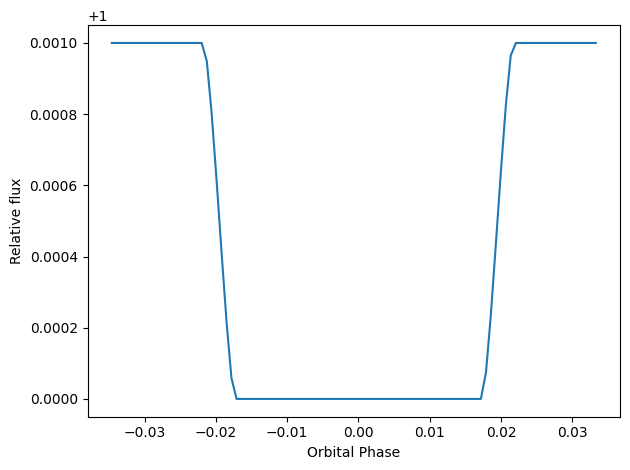

In [40]:
R_star = 1.33 * c.R_sun.value
R_planet = 1.311 * c.R_jup.value / R_star
a = 7.81
i = 87.84

params = batman.TransitParams()

params.t0 = 0 #time of inferior conjunction
params.per = 1 #orbital period
params.rp = R_planet #planet radius (in units of stellar radii)
params.a = a #semi-major axis (in units of stellar radii)
params.inc = i #orbital inclination (in degrees)
params.ecc = 0 #eccentricity
params.w = 90 #longitude of periastron (in degrees)

params.u = [0.1, 0.3] #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic" #limb darkening model

params.fp = 0.001
params.t_secondary = 0

m = batman.TransitModel(params, ph, transittype="secondary")
flux = m.light_curve(params)

plt.plot(ph, flux)
plt.ylabel("Relative flux")
plt.xlabel("Orbital Phase")
plt.tight_layout();

We can now plot the different spectra obtained in the CRIRES+ data for example:

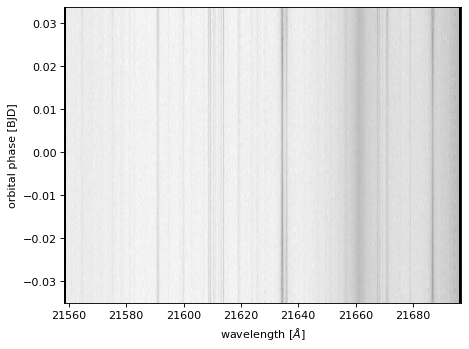

In [41]:
n = 8

f = plt.figure(dpi=80)
a = f.add_subplot(xlabel=r'wavelength [$\AA$]', ylabel=r'orbital phase [BJD]')

a.pcolormesh(wl[n], ph, spec[n]);

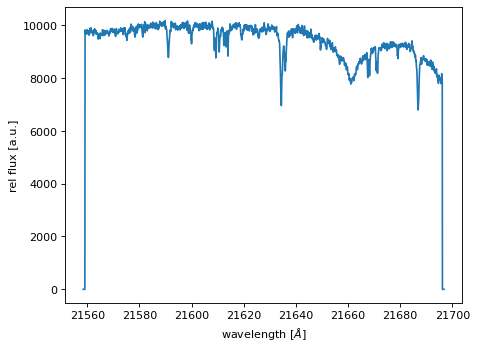

In [42]:
f = plt.figure(dpi=80)
a = f.add_subplot(xlabel=r'wavelength [$\AA$]', ylabel=r'rel flux [a.u.]')

a.plot(wl[n], spec[n,10]); #flux at 11th time series

# Detect CO and H2O

Apply Sysrem to the transmission spectrum to remove the telluric and stellar signals, leaving only the atmospheric.

In [43]:
R = np.empty((spec.shape))
Re = np.empty((spec_err.shape))
for i in range(spec.shape[0]):
    #use sysrem to construct a model of the data
    N_components = 9 #number of iterations of sysrem to use
    Msys = SysRem.FastModelSysRem(spec[i],spec_err[i],N_components) #get model of data

    #correct data using SysRem model
    R[i] = spec[i] / np.abs(Msys) - 1
    Re[i] = spec_err[i] / Msys #do the same for the uncertainties

#we also need to be careful about clearing up nans/infs etc after division
R[np.isnan(R)] = 0.
R[np.isinf(R)] = 0.
Re[Re < 0] = np.inf
Re[np.isnan(Re)] = np.inf #reset errors to infs
Re[np.isclose(Re,0)] = np.inf #reset errors to infs

Performing sysrem for order 1
 filtering zero columns
 sysrem converged after 7 iterations
 sysrem converged after 13 iterations
 sysrem converged after 10 iterations
 sysrem converged after 29 iterations
 sysrem converged after 39 iterations
 sysrem didnt converge after 100 iterations
 sysrem converged after 96 iterations
 sysrem didnt converge after 100 iterations
 sysrem didnt converge after 100 iterations
Performing sysrem for order 1
 filtering zero columns
 sysrem converged after 8 iterations
 sysrem converged after 11 iterations
 sysrem converged after 11 iterations
 sysrem converged after 34 iterations
 sysrem converged after 25 iterations
 sysrem converged after 42 iterations
 sysrem converged after 28 iterations


/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_2204/3435343604.py:9: RuntimeWarning: invalid value encountered in divide
  R[i] = spec[i] / np.abs(Msys) - 1


 sysrem converged after 72 iterations
 sysrem converged after 51 iterations
Performing sysrem for order 1
 filtering zero columns
 sysrem converged after 7 iterations
 sysrem converged after 12 iterations
 sysrem converged after 21 iterations
 sysrem converged after 33 iterations
 sysrem converged after 19 iterations
 sysrem converged after 22 iterations
 sysrem converged after 38 iterations
 sysrem converged after 48 iterations
 sysrem converged after 32 iterations
Performing sysrem for order 1
 filtering zero columns
 sysrem converged after 6 iterations
 sysrem converged after 11 iterations
 sysrem converged after 51 iterations
 sysrem converged after 32 iterations
 sysrem converged after 63 iterations
 sysrem didnt converge after 100 iterations
 sysrem didnt converge after 100 iterations
 sysrem didnt converge after 100 iterations
 sysrem didnt converge after 100 iterations
Performing sysrem for order 1
 filtering zero columns
 sysrem converged after 6 iterations
 sysrem converged a

Plot a Specific order

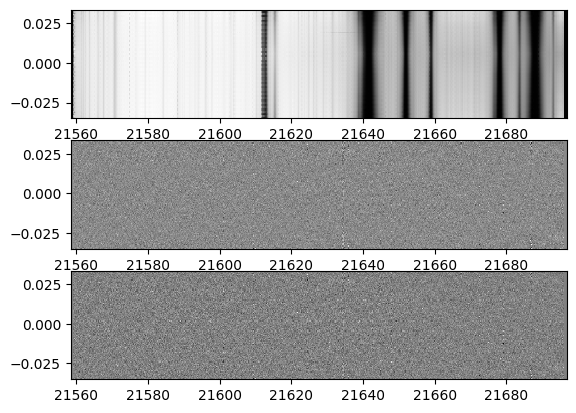

In [44]:
f,a = plt.subplots(3)
a[0].pcolormesh(wl[n],ph,Msys)
a[1].pcolormesh(wl[n],ph,R[n])
a[2].pcolormesh(wl[n],ph,R[n]/Re[n]);

Import Atmospheric Model

In [45]:
atm = np.load('models_convolve/COH2O.npz')
wl_model = atm['wl_model']
model = atm['model']

Cross correlate with model to enhance signal

In [46]:
v_sys = np.arange(-150,150,1) #define range to perform cc

CC = np.empty((spec.shape[0], spec.shape[1], v_sys.size))
for j in range((CC.shape[0])):

    W_shifted = np.outer((1-v_sys*1000./c.c.value),wl[j]) #create array of shifted wavelengths for each v_sys
    shifted_templates = np.interp(W_shifted,wl_model,model) #interpolate the template model to every v_sys

    CC[j] = np.dot(R[j]/Re[j]**2, shifted_templates.T)
    CC[j] -= np.mean(CC[j], axis=-1)[...,None] # subtract mean along columns

Plot summed CC for each order

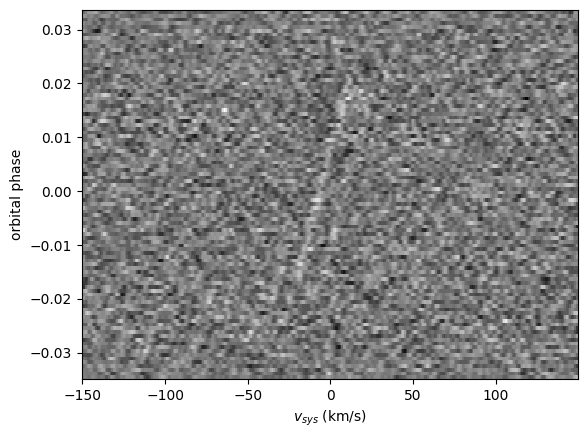

In [47]:
f = plt.figure(dpi=100)
a = f.add_subplot()
a.pcolormesh(v_sys,ph,CC.sum(axis=0))
a.set_xlabel(r'$v_{sys}$ (km/s)')
a.set_ylabel(r'orbital phase');

Create the CC map and sum it

In [48]:
K = np.arange(0, 400, 1)

tweight = (1. - flux) / np.ptp(flux)

CC_map = np.empty((spec.shape[0], K.size, v_sys.size)) # K x order x v_sys
for j in range((CC.shape[0])):
    CC_map[j] = vel_sum(ph, v_sys, CC[j], K, tweight=tweight)

CC_summed = CC_map.sum(axis=0)

Plot the summed CC map

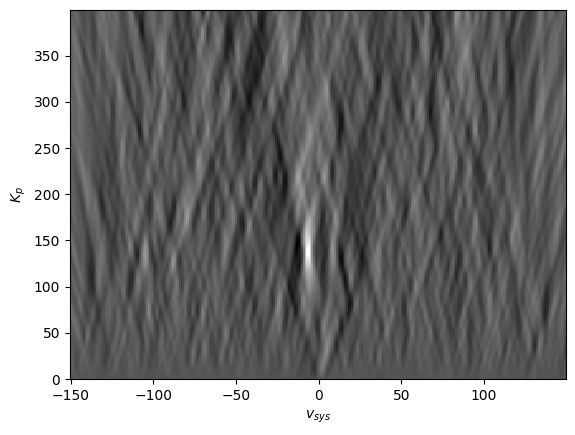

In [49]:
f = plt.figure(dpi=100)
a = f.add_subplot()

a.pcolormesh(v_sys, K, CC_summed)
#a.axhline(210,color='r',ls='--',lw=0.5)
#a.axvline(-5,color='r',ls='--',lw=0.5)
a.set_xlabel(r'$v_{sys}$')
a.set_ylabel(r'$K_{p}$');

Plot the normalized CC map

In [50]:
sl = [75,130,170,225] #indices chosen to find mean and stdev that do not take into account detection

mean = CC_summed[:,sl[0]:sl[1]].mean()/2 + CC_summed[:,sl[2]:sl[3]].mean()/2
stdev = CC_summed[:,sl[0]:sl[1]].std()/2 + CC_summed[:,sl[2]:sl[3]].std()/2

CC_norm = (CC_summed-mean)/stdev

v_sys[sl]

array([-75, -20,  20,  75])

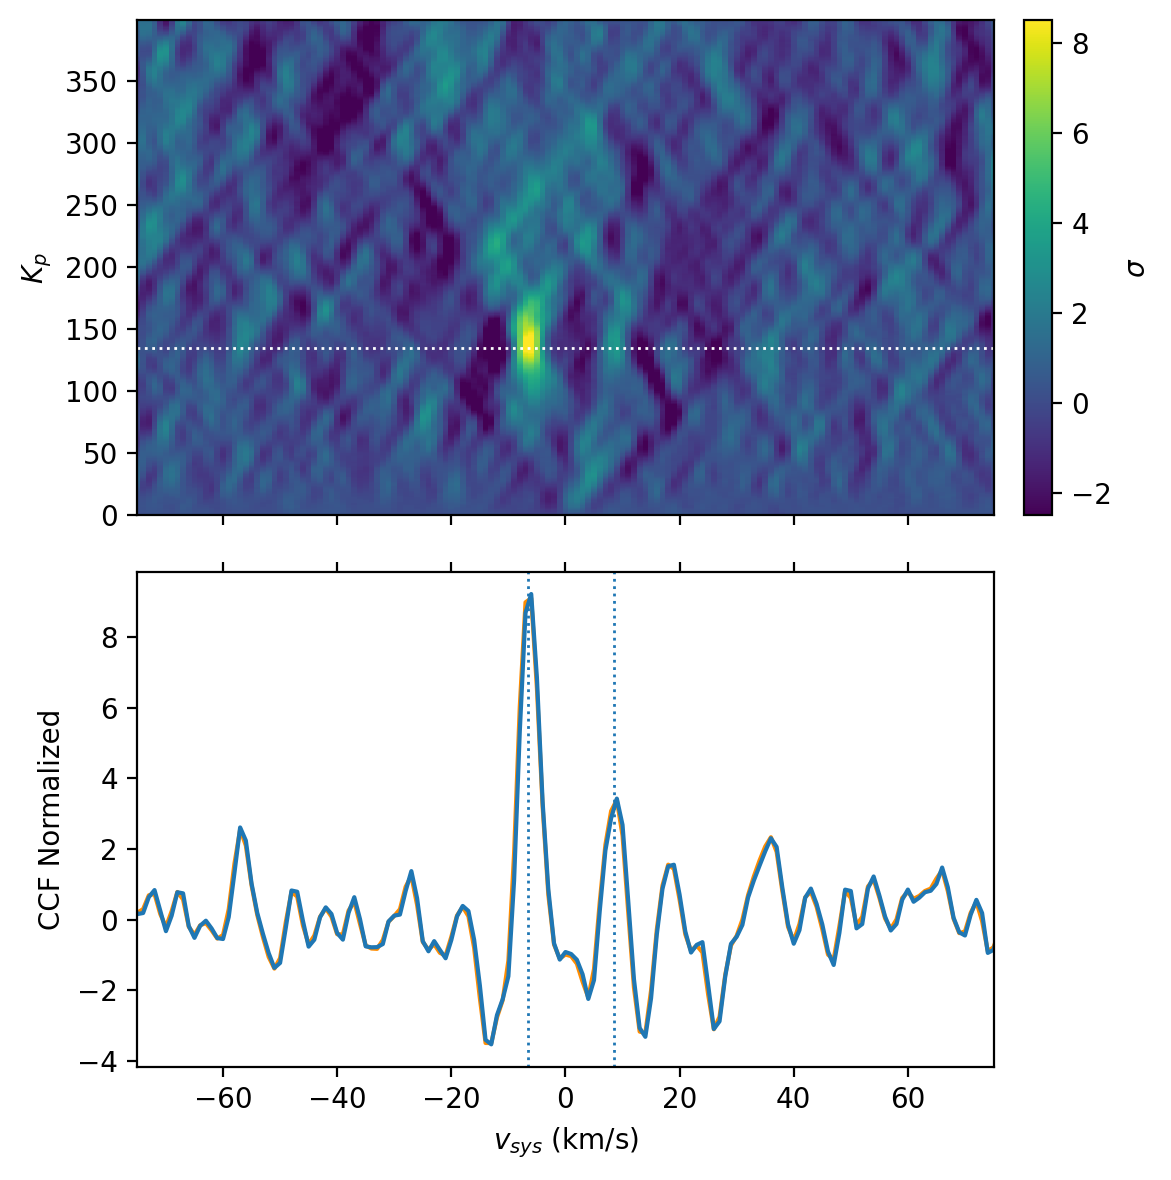

In [51]:
f = plt.figure(figsize=(6, 6), dpi=200)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=(30, 1))

a = f.add_subplot(gs[0])
b = f.add_subplot(gs[2])

K_val = 135

q = a.pcolormesh(v_sys, K, CC_norm, rasterized=True, cmap='viridis', vmin=-2.5, vmax=8.5)
a.axhline(K_val, color='w', ls=':', lw=1)
a.set_ylabel(r'$K_{p}$')
a.set_xlim(-75, 75)
a.tick_params(labelbottom=False)

#stdev colorbar
cb = plt.colorbar(q, cax=plt.subplot(gs[1]))
cb.set_label(r'$\sigma$')

b.plot(v_sys, CC_norm[K_val], 'darkorange')
b.plot(v_sys, CC_norm_no[K_val], 'tab:blue')
b.axvline(-6.5, color='tab:blue', ls='dotted',lw=1)
b.axvline(8.5, color='tab:blue', ls='dotted',lw=1)
b.set_xlim(-75, 75)
b.set_xlabel(r'$v_{sys}$ (km/s)')
b.set_ylabel('CCF Normalized')
b.tick_params(top=True)

plt.tight_layout();

We have a detection of the CO line at 6km/s.